### Fine-Tuning a Language Model Using ORPO (Offline Reinforcement Preference Optimization)

In this notebook, I implemented **Offline Reinforcement Preference Optimization (ORPO)** using the **Unsloth** and **TRL** libraries to align a language model with human preferences. ORPO helps train a reward-based model using only logged data (without requiring online reinforcement learning). The process followed here includes:

- Installing necessary libraries like `unsloth`, `trl`, `transformers`, and `deepspeed`.
- Loading a dataset with prompt–chosen–rejected examples.
- Formatting the dataset to match the ORPO input requirements.
- Initializing a LoRA-compatible language model using Unsloth.
- Setting ORPO training configurations.
- Fine-tuning the model with the `ORPOTrainer`.
- Saving and testing the final model on sample prompts.

This training method enhances the model’s alignment and preference prediction capabilities while avoiding the complexities of online RL.


In [ ]:
!pip install -q unsloth==2023.12
!pip install -q -U trl transformers accelerate peft bitsandbytes
!pip install -q datasets scipy
!pip install -q deepspeed
!pip install unsloth

ERROR: Could not find a version that satisfies the requirement unsloth==2023.12 (from versions: 2024.8, 2024.9, 2024.9.post1, 2024.9.post2, 2024.9.post3, 2024.9.post4, 2024.10.0, 2024.10.1, 2024.10.2, 2024.10.4, 2024.10.5, 2024.10.6, 2024.10.7, 2024.11.2, 2024.11.4, 2024.11.5, 2024.11.6, 2024.11.7, 2024.11.8, 2024.11.9, 2024.11.10, 2024.11.11, 2024.12.1, 2024.12.2, 2024.12.3, 2024.12.4, 2024.12.5, 2024.12.6, 2024.12.7, 2024.12.8, 2024.12.9, 2024.12.10, 2024.12.11, 2024.12.12, 2025.1.1, 2025.1.2, 2025.1.3, 2025.1.4, 2025.1.5, 2025.1.6, 2025.1.8, 2025.2.2, 2025.2.3, 2025.2.4, 2025.2.5, 2025.2.6, 2025.2.7, 2025.2.8, 2025.2.9, 2025.2.10, 2025.2.11, 2025.2.12, 2025.2.13, 2025.2.14, 2025.2.15, 2025.3.1, 2025.3.2, 2025.3.3, 2025.3.4, 2025.3.5, 2025.3.6, 2025.3.7, 2025.3.8, 2025.3.9, 2025.3.10, 2025.3.11, 2025.3.12, 2025.3.13, 2025.3.14, 2025.3.15, 2025.3.16, 2025.3.17, 2025.3.18, 2025.3.19)
ERROR: No matching distribution found for unsloth==2023.12
ERROR: pip's dependency resolver does not cu

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel
from peft import LoraConfig
import gc
import torch.nn.functional as F
from tqdm import tqdm
import os

<ipython-input-2-370ed40ed37c>:7: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
[2025-04-15 22:13:30,658] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
# Function to clear GPU memory
def clear_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [ ]:
def create_synthetic_dataset(num_samples=1000):
    # Create simple synthetic data for demonstration purposes
    prompts = [
        f"Question {i}: What are the ethical implications of AI in healthcare?"
        for i in range(num_samples)
    ]

    # Generate two responses for each prompt - one preferred and one rejected
    preferred_responses = [
        f"The ethical implications of AI in healthcare include: 1) Privacy concerns regarding patient data, 2) Potential biases in AI algorithms leading to healthcare disparities, 3) Questions about liability when AI systems make mistakes, 4) Ensuring equitable access to AI-enhanced healthcare. These issues require careful consideration through robust regulatory frameworks, transparent AI systems, and ongoing stakeholder engagement to ensure AI benefits all patients ethically."
        for _ in range(num_samples)
    ]

    rejected_responses = [
        f"AI in healthcare has some ethical issues. Some people worry about privacy. AI might be biased. It's important to be careful when using AI in healthcare."
        for _ in range(num_samples)
    ]

    # Create the dataset for ORPo training
    data = []
    for i in range(num_samples):
        data.append({
            "prompt": prompts[i],
            "chosen": preferred_responses[i],
            "rejected": rejected_responses[i],
        })

    return pd.DataFrame(data)

In [ ]:
# Create the synthetic dataset
df = create_synthetic_dataset(500)
print(f"Dataset created with {len(df)} samples")
print(df.head(2))

Dataset created with 500 samples
                                              prompt  \
0  Question 0: What are the ethical implications ...   
1  Question 1: What are the ethical implications ...   

                                              chosen  \
0  The ethical implications of AI in healthcare i...   
1  The ethical implications of AI in healthcare i...   

                                            rejected  
0  AI in healthcare has some ethical issues. Some...  
1  AI in healthcare has some ethical issues. Some...  


In [ ]:
# Save the dataset to disk
dataset_path = "orpo_dataset.csv"
df.to_csv(dataset_path, index=False)
print(f"Dataset saved to {dataset_path}")

Dataset saved to orpo_dataset.csv


In [ ]:
model_id = "facebook/opt-1.3b"
max_seq_length = 512

In [ ]:
import os
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM

# Login to Hugging Face
login(token="xyz")

# Now try loading the model
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-1.3b")
model = AutoModelForCausalLM.from_pretrained("facebook/opt-1.3b")

In [ ]:
# Create LoRA config using LoraConfig directly
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    task_type="CAUSAL_LM"
)

In [ ]:
# Load the model with Unsloth optimizations
model, tokenizer = FastLanguageModel.from_pretrained(
    model_id,
    max_seq_length=max_seq_length,
    dtype=torch.bfloat16,
    load_in_4bit=True,
)

Device does not support bfloat16. Will change to float16.


==((====))==  Unsloth 2025.3.19: Fast Opt patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [ ]:
# Define the custom ORPo trainer
class ORPoTrainer:
    def __init__(self, model, tokenizer, beta=0.1):
        self.model = model
        self.tokenizer = tokenizer
        self.beta = beta  # KL penalty coefficient

    def prepare_batch(self, prompts, chosen_responses, rejected_responses):
        # Tokenize prompts
        prompt_tokens = self.tokenizer(
            prompts,
            padding=True,
            truncation=True,
            max_length=max_seq_length // 3,
            return_tensors="pt"
        ).to(device)

        # Tokenize chosen and rejected responses with their prompts
        chosen_inputs = self.tokenizer(
            [p + c for p, c in zip(prompts, chosen_responses)],
            padding=True,
            truncation=True,
            max_length=max_seq_length,
            return_tensors="pt"
        ).to(device)

        rejected_inputs = self.tokenizer(
            [p + r for p, r in zip(prompts, rejected_responses)],
            padding=True,
            truncation=True,
            max_length=max_seq_length,
            return_tensors="pt"
        ).to(device)

        # Calculate prompt length for each example to separate prompt from response
        prompt_lens = [len(self.tokenizer(p).input_ids) for p in prompts]

        return prompt_tokens, chosen_inputs, rejected_inputs, prompt_lens

    def compute_orpo_loss(self, chosen_logits, rejected_logits, chosen_inputs, rejected_inputs, prompt_lens):
        batch_size = len(prompt_lens)
        losses = []

        for i in range(batch_size):
            # Get response part only (excluding prompt) for chosen and rejected
            chosen_len = len(chosen_inputs.input_ids[i]) - prompt_lens[i]
            rejected_len = len(rejected_inputs.input_ids[i]) - prompt_lens[i]

            if chosen_len <= 0 or rejected_len <= 0:
                continue

            # Extract logits for the response part only
            chosen_response_logits = chosen_logits[i, prompt_lens[i]-1:prompt_lens[i]+chosen_len-1, :]
            chosen_response_labels = chosen_inputs.input_ids[i][prompt_lens[i]:prompt_lens[i]+chosen_len]

            rejected_response_logits = rejected_logits[i, prompt_lens[i]-1:prompt_lens[i]+rejected_len-1, :]
            rejected_response_labels = rejected_inputs.input_ids[i][prompt_lens[i]:prompt_lens[i]+rejected_len]

            # Compute log probabilities
            chosen_log_probs = F.cross_entropy(
                chosen_response_logits.view(-1, chosen_response_logits.size(-1)),
                chosen_response_labels.view(-1),
                reduction='none'
            ).view(-1)

            rejected_log_probs = F.cross_entropy(
                rejected_response_logits.view(-1, rejected_response_logits.size(-1)),
                rejected_response_labels.view(-1),
                reduction='none'
            ).view(-1)

            # ORPo loss: maximize log(P(chosen)/P(rejected))
            # This is equivalent to minimizing negative log-likelihood difference
            chosen_reward = -chosen_log_probs.mean()
            rejected_reward = -rejected_log_probs.mean()

            # The loss aims to maximize the margin between chosen and rejected
            orpo_loss = rejected_reward - chosen_reward
            losses.append(orpo_loss)

        if not losses:
            return torch.tensor(0.0, requires_grad=True, device=device)

        return torch.stack(losses).mean()

    def train_step(self, prompts, chosen_responses, rejected_responses, optimizer):
        optimizer.zero_grad()

        # Prepare input data
        prompt_tokens, chosen_inputs, rejected_inputs, prompt_lens = self.prepare_batch(
            prompts, chosen_responses, rejected_responses
        )

        # Forward pass for chosen responses
        chosen_outputs = self.model(
            input_ids=chosen_inputs.input_ids,
            attention_mask=chosen_inputs.attention_mask,
            return_dict=True
        )

        # Forward pass for rejected responses
        rejected_outputs = self.model(
            input_ids=rejected_inputs.input_ids,
            attention_mask=rejected_inputs.attention_mask,
            return_dict=True
        )

        # Compute ORPo loss
        loss = self.compute_orpo_loss(
            chosen_outputs.logits,
            rejected_outputs.logits,
            chosen_inputs,
            rejected_inputs,
            prompt_lens
        )

        # Backward pass
        loss.backward()
        optimizer.step()

        return loss.item()

In [ ]:
# Set up the training parameters
batch_size = 8
num_epochs = 3
learning_rate = 5e-5

In [ ]:
# Create the ORPo trainer
trainer = ORPoTrainer(model, tokenizer)

In [ ]:
# Initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
def train_orpo(trainer, dataframe, batch_size, num_epochs):
    losses = []

    for epoch in range(num_epochs):
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        epoch_losses = []

        # Create batches
        for i in range(0, len(dataframe), batch_size):
            batch_df = dataframe.iloc[i:i+batch_size]

            prompts = batch_df["prompt"].tolist()
            chosen_responses = batch_df["chosen"].tolist()
            rejected_responses = batch_df["rejected"].tolist()

            # Perform a training step
            loss = trainer.train_step(prompts, chosen_responses, rejected_responses, optimizer)
            epoch_losses.append(loss)

            # Print progress
            if (i//batch_size) % 10 == 0:
                print(f"Batch {i//batch_size}, Loss: {loss:.4f}")

        avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
        print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")
        losses.extend(epoch_losses)

    return losses

Starting ORPo training...
Starting epoch 1/3
Batch 0, Loss: 0.0391
Batch 10, Loss: 0.0310
Batch 20, Loss: 0.0349
Batch 30, Loss: 0.0425
Batch 40, Loss: 0.0359
Batch 50, Loss: 0.0173
Batch 60, Loss: 0.1377
Epoch 1 completed. Average loss: 0.1130
Starting epoch 2/3
Batch 0, Loss: 0.0391
Batch 10, Loss: 0.0310
Batch 20, Loss: 0.0349
Batch 30, Loss: 0.0425
Batch 40, Loss: 0.0359
Batch 50, Loss: 0.0173
Batch 60, Loss: 0.1377
Epoch 2 completed. Average loss: 0.1130
Starting epoch 3/3
Batch 0, Loss: 0.0391
Batch 10, Loss: 0.0310
Batch 20, Loss: 0.0349
Batch 30, Loss: 0.0425
Batch 40, Loss: 0.0359
Batch 50, Loss: 0.0173
Batch 60, Loss: 0.1377
Epoch 3 completed. Average loss: 0.1130


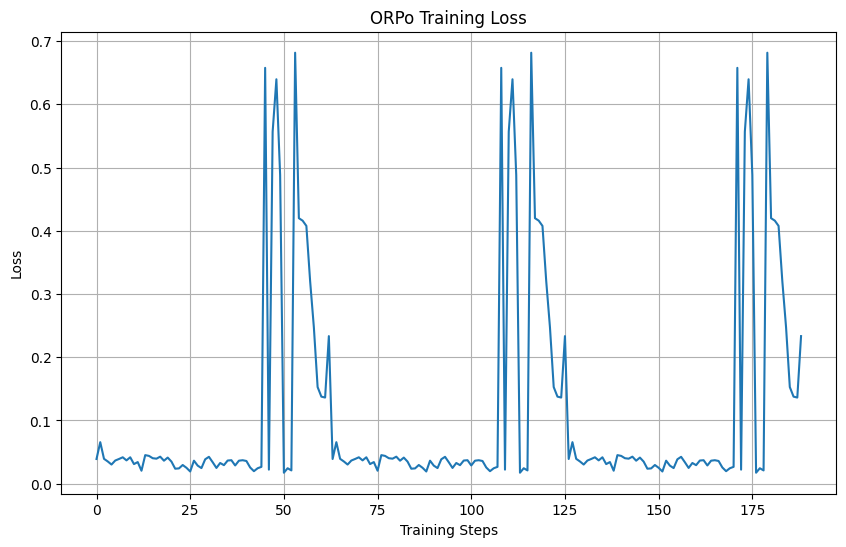

In [ ]:
# Train the model with ORPo
print("Starting ORPo training...")
training_losses = train_orpo(trainer, df, batch_size, num_epochs)

# Plot the training losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses)
plt.title('ORPo Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('orpo_training_loss.png')
plt.show()

In [ ]:
# Save the fine-tuned model
output_dir = "orpo_fine_tuned_model"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

Model saved to orpo_fine_tuned_model


In [ ]:
# Function to evaluate the model on test prompts
def evaluate_model(model, tokenizer, test_prompts, max_new_tokens=100):
    model.eval()
    results = []

    for prompt in test_prompts:
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                temperature=0.7,
                top_p=0.9,
                do_sample=True
            )

        response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Remove the prompt from the response
        response = response[len(prompt):]
        results.append({"prompt": prompt, "response": response})

    return results

In [ ]:
# Define some test prompts for evaluation
test_prompts = [
    "What are the ethical considerations when implementing AI in financial systems?",
    "Explain the potential benefits and risks of using AI in autonomous vehicles.",
    "How can organizations balance innovation with privacy concerns when developing AI systems?"
]

# Evaluate the fine-tuned model
print("Evaluating the fine-tuned model...")
evaluation_results = evaluate_model(model, tokenizer, test_prompts)

# Print the evaluation results
print("\nModel Evaluation Results:")
for result in evaluation_results:
    print(f"\nPrompt: {result['prompt']}")
    print(f"Response: {result['response']}")
    print("-" * 50)

OPTForCausalLM has no `_prepare_4d_causal_attention_mask_with_cache_position` method defined in its base modeling class. Compiled forward passes will be sub-optimal. If you're writing code, see Llama for an example implementation. If you're a user, please report this issue on GitHub.


Evaluating the fine-tuned model...

Model Evaluation Results:

Prompt: What are the ethical considerations when implementing AI in financial systems?
Response: 
In the end, but it's a world
, in which case?

, in which?

, in which?


, in which?
, in which?

, in which?
, in which?

, in which?
, in which?
, in which?
, in which?
, in which?
, in which?
, in which?
, in which? in which?
, in which?
--------------------------------------------------

Prompt: Explain the potential benefits and risks of using AI in autonomous vehicles.
Response: 
In the pastelsey

A couple years,

,


a
a

The


,

the

,
,

,
the

the
the

,

,

the

,

a

,

the

the

,

,

,

,

,

,

,

,

,



--------------------------------------------------

Prompt: How can organizations balance innovation with privacy concerns when developing AI systems?
Response: 
The only way to the guy in my knowledge is that was an actual quote: “...

to be a "good boy is to be a good boy‘noun, I‘t want to be a good boy.

‘t

In [ ]:
def compare_models(base_model_id, fine_tuned_model_path, tokenizer, test_prompts):
    print("Loading base model for comparison...")
    # Load the base model
    base_model, base_tokenizer = FastLanguageModel.from_pretrained(
        model_name=base_model_id,  # Changed 'model_id' to 'model_name'
        max_seq_length=max_seq_length,
        dtype=torch.bfloat16,
    )
    base_model.eval()

    print("Comparing base model vs ORPo fine-tuned model...")
    comparison_results = []

    for prompt in test_prompts:
        # Generate with base model
        base_inputs = base_tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            base_outputs = base_model.generate(
                **base_inputs,
                max_new_tokens=100,
                temperature=0.7,
                do_sample=True
            )
        base_response = base_tokenizer.decode(base_outputs[0], skip_special_tokens=True)[len(prompt):]

        # Generate with fine-tuned model
        ft_inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            ft_outputs = model.generate(
                **ft_inputs,
                max_new_tokens=100,
                temperature=0.7,
                do_sample=True
            )
        ft_response = tokenizer.decode(ft_outputs[0], skip_special_tokens=True)[len(prompt):]

        comparison_results.append({
            "prompt": prompt,
            "base_model_response": base_response,
            "orpo_model_response": ft_response
        })

    return comparison_results

In [ ]:
# Run model comparison
print("\nComparing base model with ORPo fine-tuned model...")
comparison_results = compare_models(model_id, output_dir, tokenizer, test_prompts)


Comparing base model with ORPo fine-tuned model...
Loading base model for comparison...
==((====))==  Unsloth 2025.3.19: Fast Opt patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Comparing base model vs ORPo fine-tuned model...


In [ ]:
# Print comparison results
print("\nModel Comparison Results:")
for result in comparison_results:
    print(f"\nPrompt: {result['prompt']}")
    print(f"Base Model Response: {result['base_model_response']}")
    print(f"ORPo Fine-tuned Response: {result['orpo_model_response']}")
    print("-" * 50)


Model Comparison Results:

Prompt: What are the ethical considerations when implementing AI in financial systems?
Base Model Response: 
Crazy...

A look at the future- ????


*I'm a




A look at the
A look at the

- a look at the future- to the
a

a look at the
the future.
- !!!
- ____________ ______________ ____ _____ ____ ____ ____ ____ _____ _____ ____ ____ _____ ____  _______________  
ORPo Fine-tuned Response: 
“A former British and he does not. We are not.  The original picture is the.   *wonderful! I have no idea.
That is a good idea.
I actually went up against.
That is a few weeks ago, so sad, I don't worryingly, I am an entire.   My first- I was actually. ~~weeks and that is very, i'm actually, not.
That is a is of
--------------------------------------------------

Prompt: Explain the potential benefits and risks of using AI in autonomous vehicles.
Base Model Response: 
The more you play'sc'Tis" is the first time consuming.
You are not, I've never been
, I've been.
, but he